# Spray Vision Report Plots

This notebook generates and saves all requested plots using the processed dataset and trained models.

**Inputs:**
- time, chamb_pressure, cham_temp, injection_pres, density, viscosity

**Targets:**
- angle_mie, length_mie, angle_shadow, length_shadow

All plots will be saved in a dedicated `plots` folder in the project root.

In [1]:
import os
from pathlib import Path

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Set default figure size to 8x8 inches (800x800 pixels at 100 dpi)
plt.rcParams['figure.figsize'] = (8, 8)

# Ensure plots folder exists
os.makedirs("plots", exist_ok=True)

In [2]:
df = pd.read_csv("data/processed/preprocessed_dataset.csv")

rename_map = {
    "Time_ms": "time",
    "Pc_bar": "chamb_pressure",
    "Tc_K": "cham_temp",
    "Pinj_bar": "injection_pres",
    "rho_kgm3": "density",
    "mu_Pas": "viscosity",
    "angle_shadow_deg": "angle_shadow",
    "len_shadow_L_D": "length_shadow",
    "angle_mie_deg": "angle_mie",
    "len_mie_L_D": "length_mie",
}

df = df.rename(columns=rename_map)
INPUTS = ["time", "chamb_pressure", "cham_temp", "injection_pres", "density", "viscosity"]
TARGETS = ["angle_mie", "length_mie", "angle_shadow", "length_shadow"]

print(f"Dataset Loaded. Shape: {df.shape}")

Dataset Loaded. Shape: (726, 11)


## 1. Time-dependent spray angle and spray length (Shadowgraph and Mie) for one experimental run

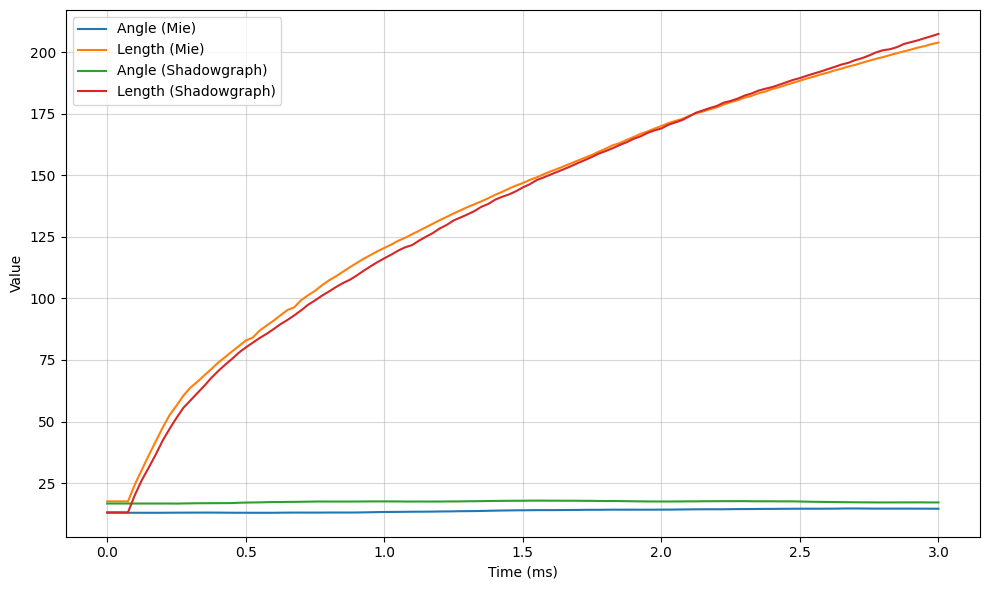

In [3]:
run_df = df.iloc[:121]
plt.figure(figsize=(10, 6))
plt.plot(run_df["time"], run_df["angle_mie"], label="Angle (Mie)")
plt.plot(run_df["time"], run_df["length_mie"], label="Length (Mie)")
plt.plot(run_df["time"], run_df["angle_shadow"], label="Angle (Shadowgraph)")
plt.plot(run_df["time"], run_df["length_shadow"], label="Length (Shadowgraph)")
plt.xlabel("Time (ms)")
plt.ylabel("Value")
plt.grid(True, alpha=0.5)
plt.legend()
plt.tight_layout()
plt.savefig("plots/1_time_dependent_spray_angle_length.png")
plt.show()

## 2. Scatter plots: Chamber Temperature vs Angle (Mie), Chamber Pressure vs Angle (Shadowgraph)

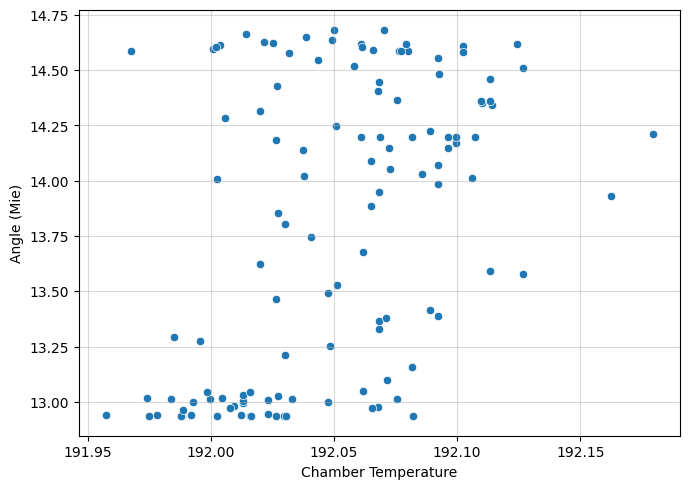

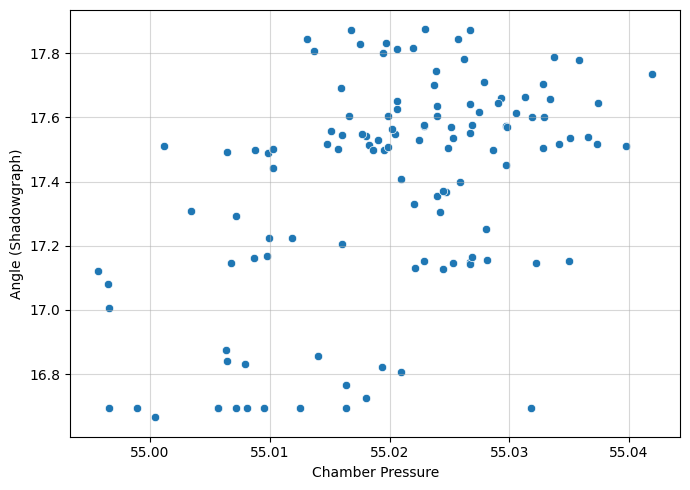

In [4]:
plt.figure(figsize=(7, 5))
sns.scatterplot(x="cham_temp", y="angle_mie", data=run_df)
plt.xlabel("Chamber Temperature")
plt.ylabel("Angle (Mie)")
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.savefig("plots/2a_cham_temp_vs_angle_mie.png")
plt.show()

plt.figure(figsize=(7, 5))
sns.scatterplot(x="chamb_pressure", y="angle_shadow", data=run_df)
plt.xlabel("Chamber Pressure")
plt.ylabel("Angle (Shadowgraph)")
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.savefig("plots/2b_chamb_pressure_vs_angle_shadow.png")
plt.show()


## 3. Correlation heatmap of features vs targets

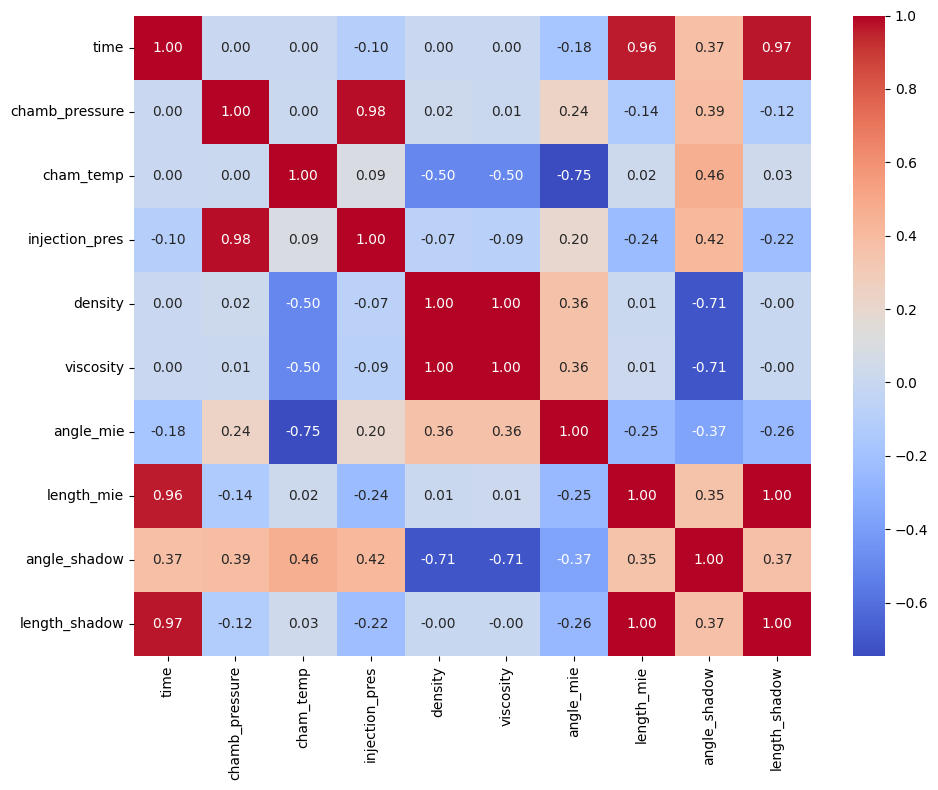

In [5]:
corr = df[INPUTS + TARGETS].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.tight_layout()
plt.savefig("plots/3_correlation_heatmap.png")
plt.show()

## 4. Predicted vs Actual values of best performing model for each target

In [6]:
# Load and prepare data for KNN model predictions
X = df[INPUTS].values
Y_shadow = df[["angle_shadow", "length_shadow"]].values
Y_mie = df[["angle_mie", "length_mie"]].values

# Split into train and test sets (80-20)
X_train, X_test, y_shadow_train, y_shadow_test, y_mie_train, y_mie_test = train_test_split(
    X, Y_shadow, Y_mie, test_size=0.2, random_state=42
)


# Function to generate predictions and return true vs predicted values using only KNN model
def get_knn_predictions(X_tr, X_te, y_tr, y_te):
    knn_model_path = "models/KNN_regressor.joblib"
    knn_model = joblib.load(knn_model_path)
    knn_model.fit(X_tr, y_tr)
    y_pred = knn_model.predict(X_te)
    return y_te, y_pred


# Get predictions for both output sets
y_shadow_true, y_shadow_pred = get_knn_predictions(X_train, X_test, y_shadow_train, y_shadow_test)
y_mie_true, y_mie_pred = get_knn_predictions(X_train, X_test, y_mie_train, y_mie_test)

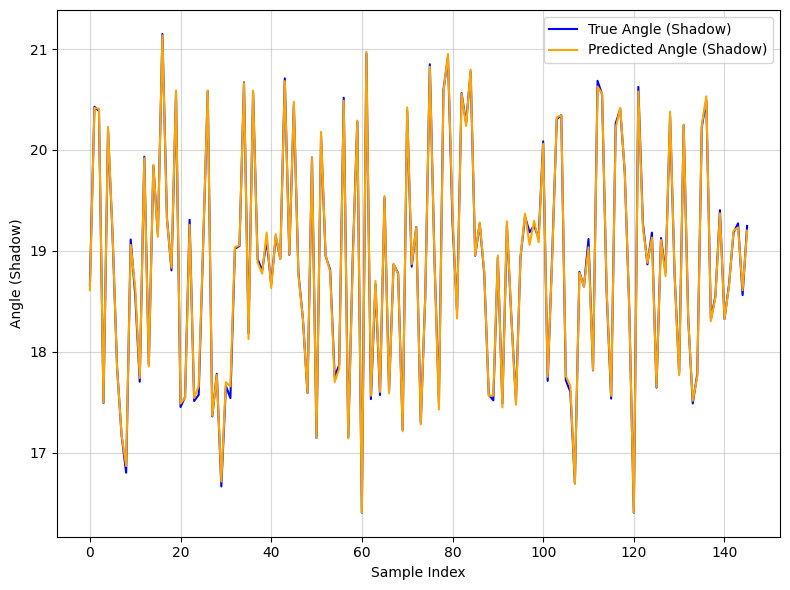

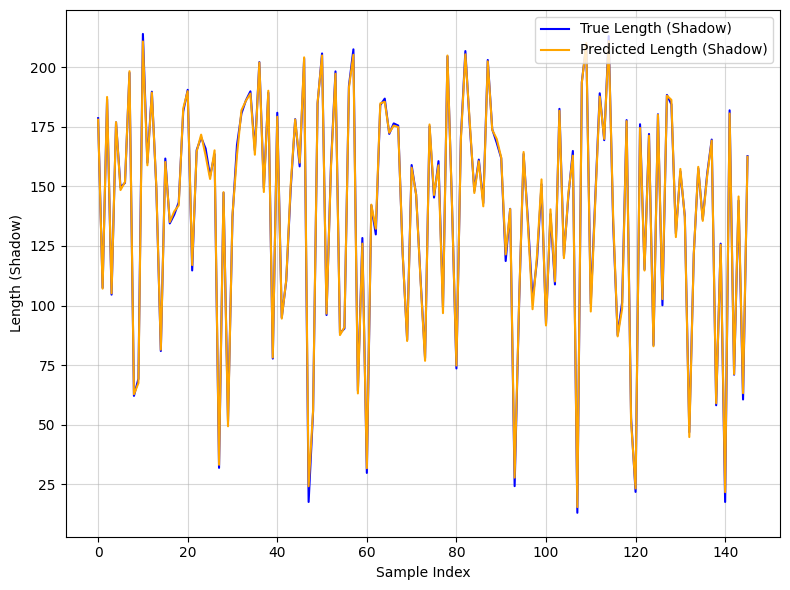

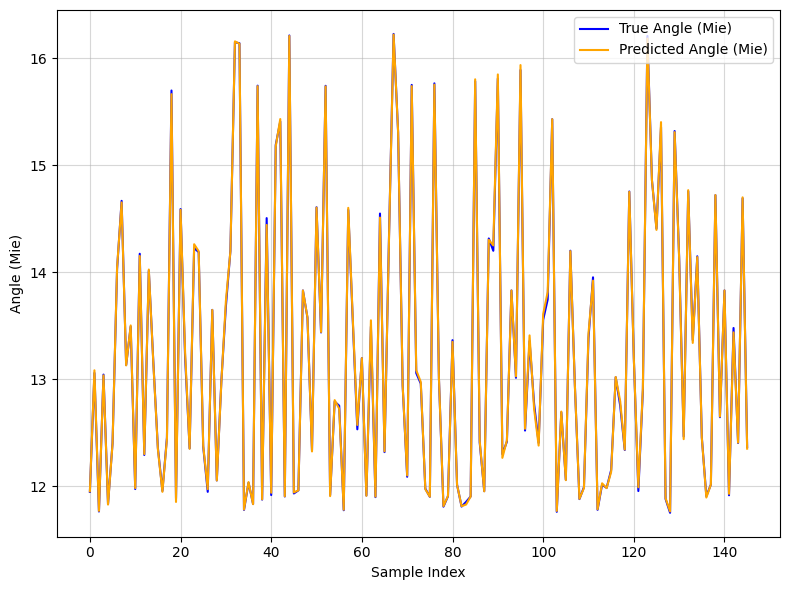

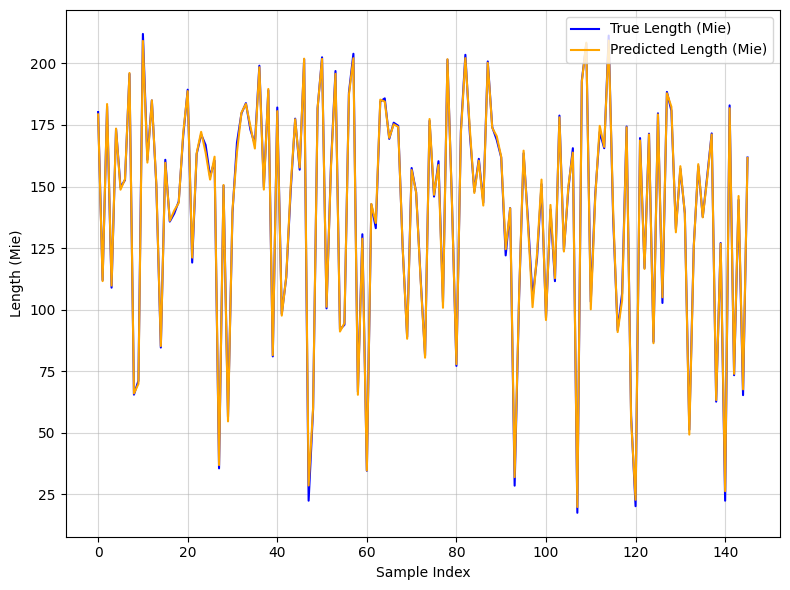

In [7]:
# Function to plot and save individual time series for each variable (angle/length, shadow/mie)
def plot_individual_time_series_separate(y_true, y_pred, label):
    plt.figure(figsize=(8, 6))
    plt.plot(y_true, label=f"True {label}", color="blue")
    plt.plot(y_pred, label=f"Predicted {label}", color="orange")
    plt.xlabel("Sample Index")
    plt.ylabel(label)
    plt.grid(True, alpha=0.5)
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.savefig(f"plots/4_predicted_vs_actual_line_plot_for_{label}.png")
    plt.show()


# Shadow: angle & length
plot_individual_time_series_separate(y_shadow_true[:, 0], y_shadow_pred[:, 0], "Angle (Shadow)")
plot_individual_time_series_separate(y_shadow_true[:, 1], y_shadow_pred[:, 1], "Length (Shadow)")

# Mie: angle & length
plot_individual_time_series_separate(y_mie_true[:, 0], y_mie_pred[:, 0], "Angle (Mie)")
plot_individual_time_series_separate(y_mie_true[:, 1], y_mie_pred[:, 1], "Length (Mie)")


## 5. True vs Predicted values across all 6 ML models for each target

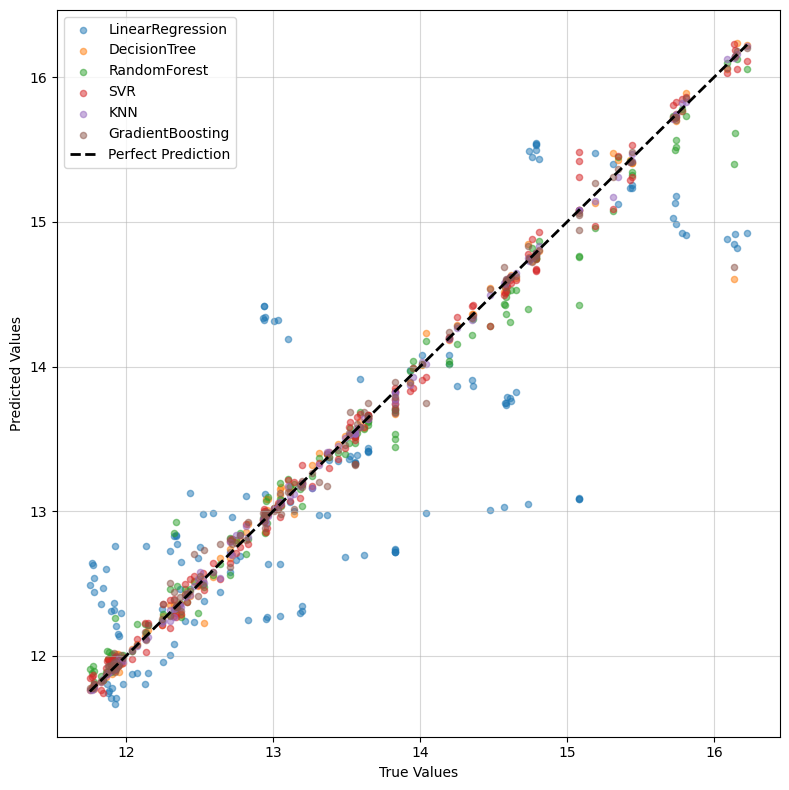

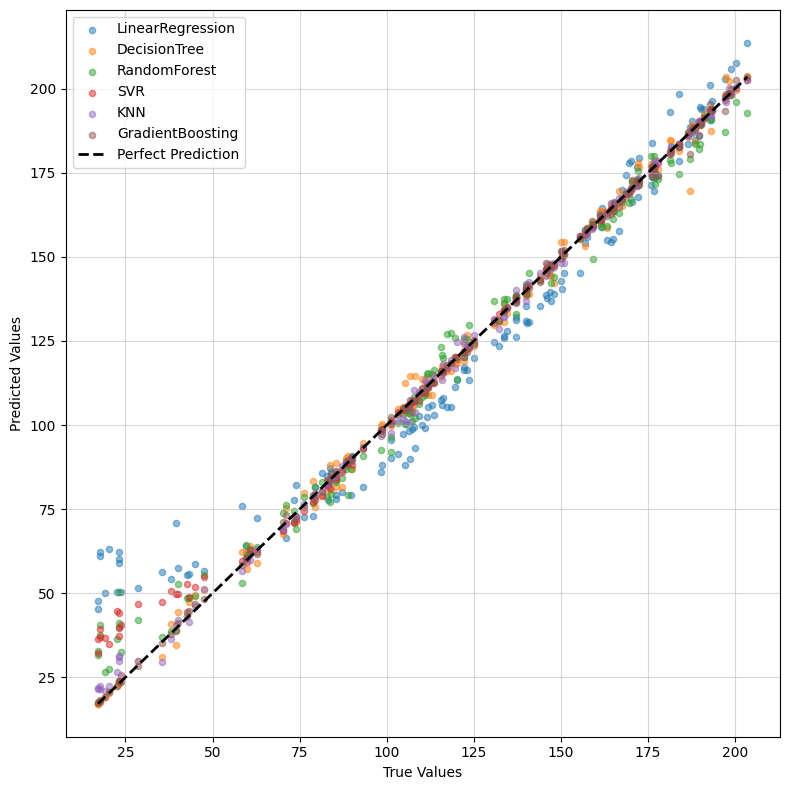

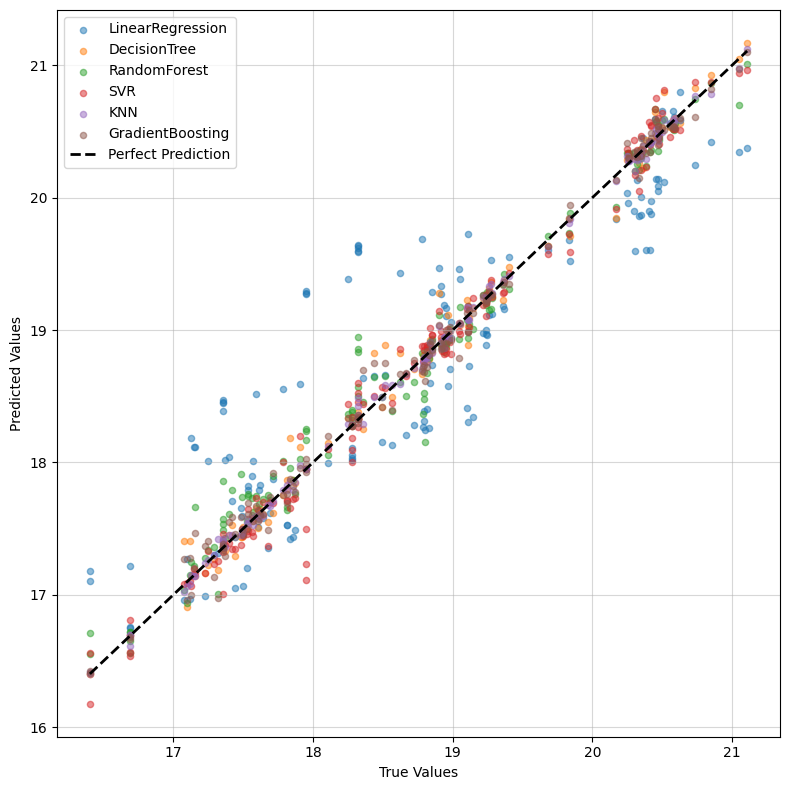

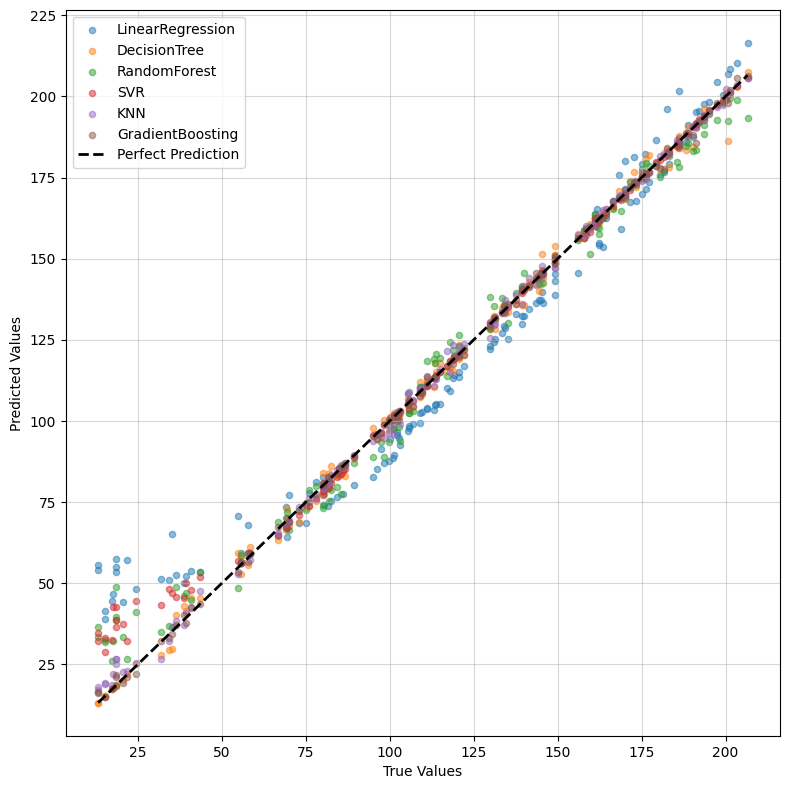

In [8]:
X, y = df[INPUTS], df[TARGETS]
runs = df["run"]
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.20, random_state=42, stratify=runs)

# List of model names to load
model_names = [
    "LinearRegression",
    "DecisionTree",
    "RandomForest",
    "SVR",
    "KNN",
    "GradientBoosting",
]

# Iterate through each target variable
for target_index, target in enumerate(TARGETS):
    plt.figure(figsize=(8, 8))  # Create a new figure for each target and adjust figure size

    # Iterate through each trained model
    for mdl_name in model_names:
        model_path = f"models/{mdl_name}_regressor.joblib"
        if os.path.exists(model_path):
            model = joblib.load(model_path)
            y_pred = model.predict(X_te)[:, target_index]  # Get predictions for the current target
            plt.scatter(
                y_te[target], y_pred, label=mdl_name, alpha=0.5, s=20
            )  # Create scatter plot
        else:
            print(f"Model {mdl_name} not found.")

    # Add a diagonal line for reference
    max_val = max(y_te[target].max(), y_pred.max())
    min_val = min(y_te[target].min(), y_pred.min())
    plt.plot([min_val, max_val], [min_val, max_val], "k--", lw=2, label="Perfect Prediction")

    # plt.title(f'{target} - Parity Plot')
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.legend()
    plt.grid(True, alpha=0.5)
    plt.tight_layout()
    plt.savefig(f"plots/5_parity_plot_for_{target}.png")
    plt.show()

## 6. Residual analysis for Angle (Mie)

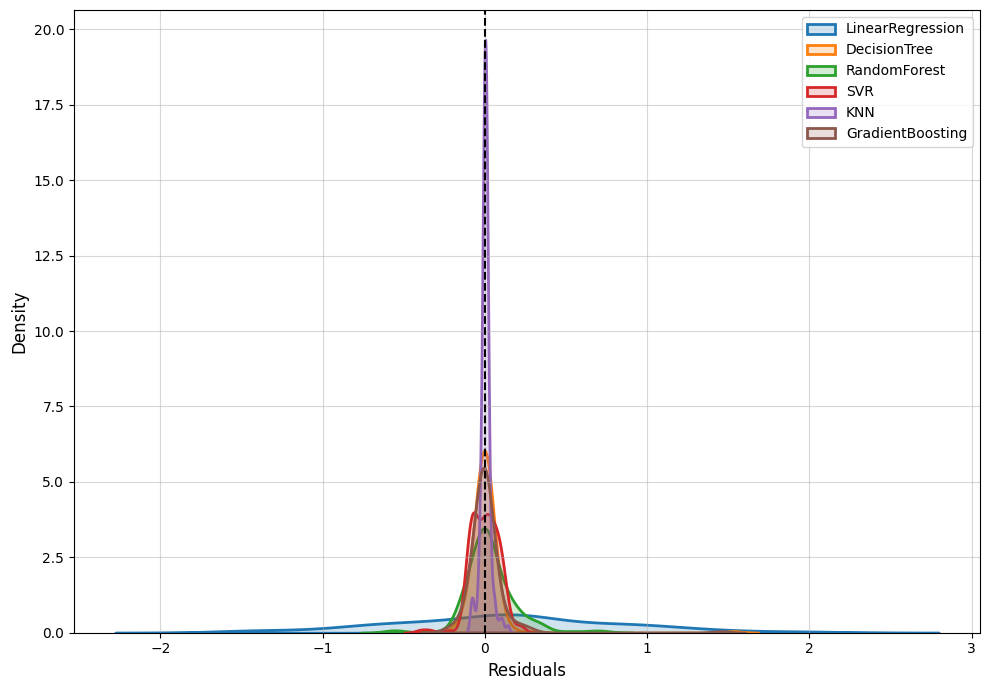

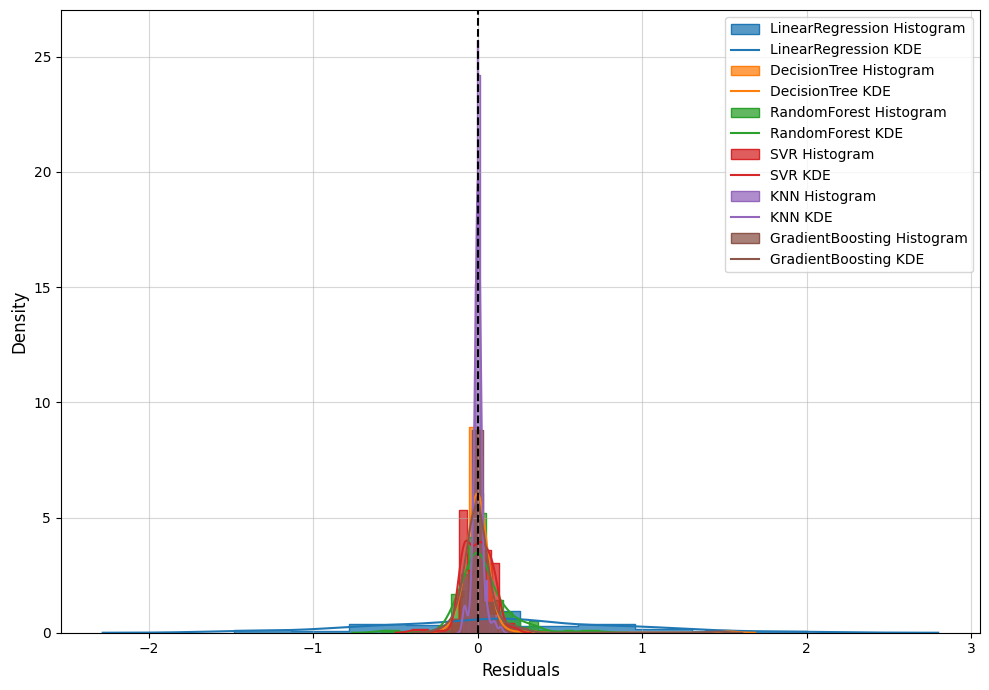

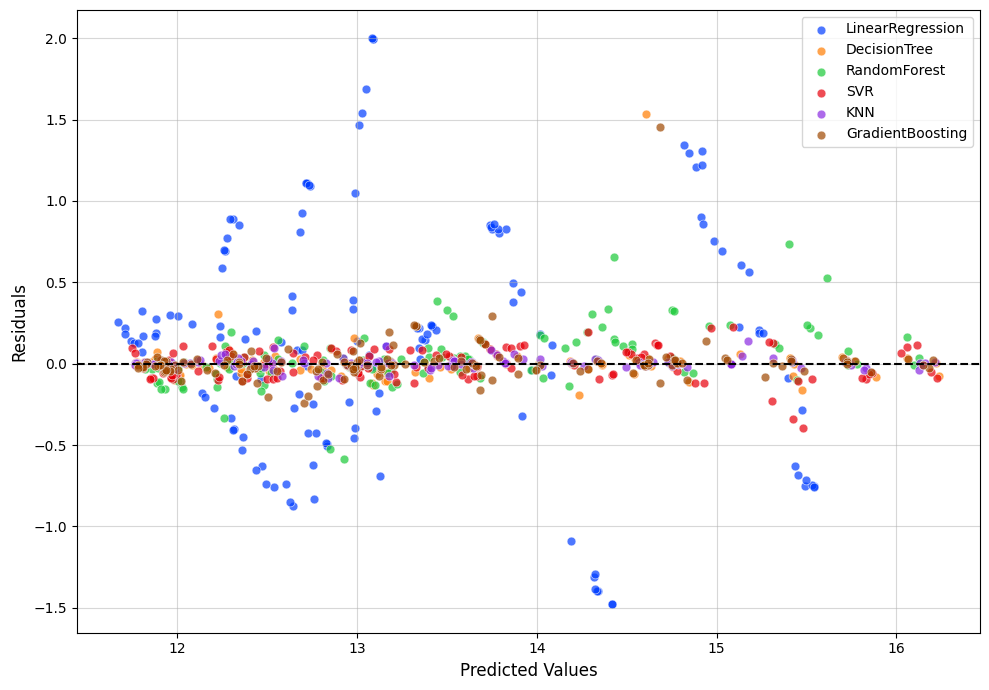

In [9]:
TARGET_FOR_ANALYSIS = "angle_mie"

# Get the index of our target variable for slicing model outputs
target_index = TARGETS.index(TARGET_FOR_ANALYSIS)
# Get the true values for our specific target
y_te_target = y_te[TARGET_FOR_ANALYSIS]

results = {}

for mdl_name in model_names:
    model_path = f"models/{mdl_name}_regressor.joblib"
    if os.path.exists(model_path):
        model = joblib.load(model_path)

        # Make predictions on the test set
        y_pred_all = model.predict(X_te)

        # Isolate predictions for the specific target
        # This handles multi-output regressors by slicing the correct column
        y_pred_target = y_pred_all[:, target_index]

        # Calculate residuals (error)
        residuals = y_te_target - y_pred_target

        # Store results for plotting
        results[mdl_name] = {"predictions": y_pred_target, "residuals": residuals}
    else:
        print(f"Warning: Model file not found at {model_path}. Skipping {mdl_name}.")


# Plot 1: KDE Residual Plots
plt.figure(figsize=(10, 7))
ax1 = plt.gca()
for name, data in results.items():
    sns.kdeplot(data["residuals"], ax=ax1, label=name, fill=True, alpha=0.2, lw=2)
ax1.axvline(x=0, color="k", linestyle="--", linewidth=1.5)
# ax1.set_title('KDE Residual Plots For Angle (Mie) Across All Models', fontsize=14)
ax1.set_xlabel("Residuals", fontsize=12)
ax1.set_ylabel("Density", fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.5)
plt.tight_layout()
plt.savefig("plots/6a_kde_residuals_angle_mie.png")
plt.show()


# Plot 2: Histogram and KDE Overlays
plt.figure(figsize=(10, 7))
ax2 = plt.gca()
for name, data in results.items():
    sns.histplot(
        data["residuals"],
        ax=ax2,
        label=f"{name} Histogram",
        stat="density",
        element="step",
    )
    sns.kdeplot(data["residuals"], ax=ax2, label=f"{name} KDE")
ax2.axvline(x=0, color="k", linestyle="--", linewidth=1.5)
# ax2.set_title('Histogram And KDE Overlays of Angle (Mie) Residuals', fontsize=14)
ax2.set_xlabel("Residuals", fontsize=12)
ax2.set_ylabel("Density", fontsize=12)
# Consolidate legends by creating a single legend from all plot elements
handles, labels = ax2.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
ax2.legend(unique_labels.values(), unique_labels.keys())
ax2.grid(True, alpha=0.5)
plt.tight_layout()
plt.savefig("plots/6b_hist_kde_residuals_angle_mie.png")
plt.show()


# Plot 3: Residuals vs. Predicted Values
plt.figure(figsize=(10, 7))
ax3 = plt.gca()
# Use a color palette for better distinction
palette = sns.color_palette("bright", len(results))
for i, (name, data) in enumerate(results.items()):
    sns.scatterplot(
        x=data["predictions"],
        y=data["residuals"],
        ax=ax3,
        label=name,
        alpha=0.7,
        color=palette[i],
        s=40,  # Adjust marker size
    )
ax3.axhline(y=0, color="k", linestyle="--", linewidth=1.5)
# ax3.set_title('Residuals vs. Predicted Values for Angle (Mie)', fontsize=14)
ax3.set_xlabel("Predicted Values", fontsize=12)
ax3.set_ylabel("Residuals", fontsize=12)
ax3.legend()
ax3.grid(True, alpha=0.5)
plt.tight_layout()
plt.savefig("plots/6c_residuals_vs_predicted_angle_mie.png")
plt.show()

## 7. Feature importance bar chart for Random Forest model

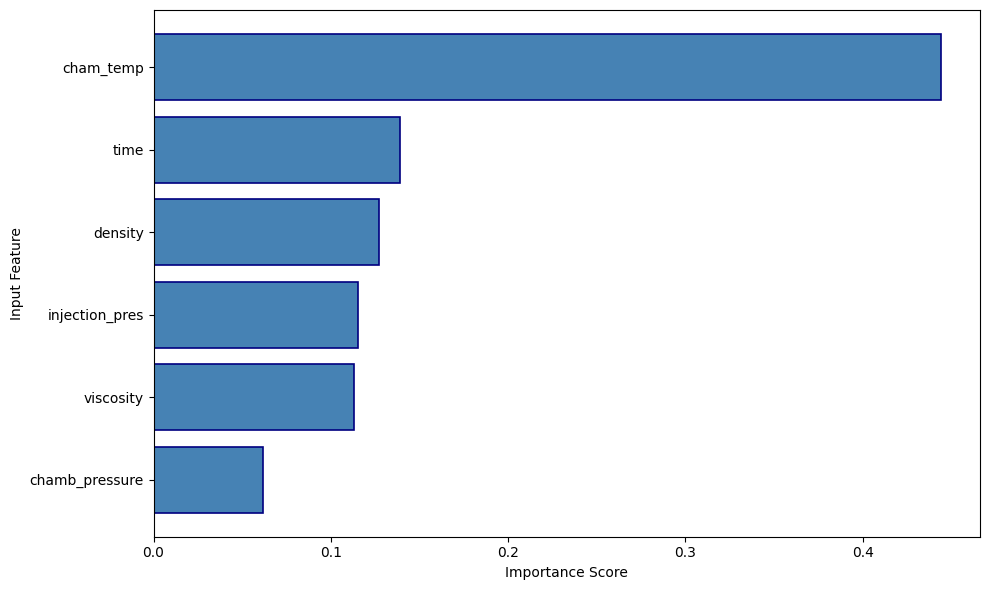

In [10]:
notebook_dir = Path.cwd()
models_dir = notebook_dir / "models"
model_path = models_dir / "RandomForest_regressor.joblib"

rf_model = joblib.load(model_path)
multi_output_regressor = rf_model.named_steps["reg"]
estimators = multi_output_regressor.estimators_

feature_names = ["time", "chamb_pressure", "cham_temp", "injection_pres", "density", "viscosity"]
target_names = ["angle_mie", "length_mie", "angle_shadow", "length_shadow"]
rf_angle_mie = estimators[target_names.index("angle_mie")]

feature_importances = rf_angle_mie.feature_importances_
importance_df = pd.DataFrame(
    {"Feature": feature_names, "Importance": feature_importances}
).sort_values("Importance", ascending=False)
importance_df["Percentage"] = (
    importance_df["Importance"] / importance_df["Importance"].sum()
) * 100

plt.figure(figsize=(10, 6))
bars = plt.barh(
    importance_df["Feature"],
    importance_df["Importance"],
    color="steelblue",
    edgecolor="navy",
    linewidth=1.2,
)
plt.xlabel("Importance Score")
plt.ylabel("Input Feature")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig("plots/7_feature_importance_angle_mie_rf.png")
plt.show()

## 8. ANN vs best performing ML model: True vs Predicted plots for spray length/angle (Shadowgraph and Mie)

In [11]:
ann_actuals = pd.read_csv("outputs/ANN_improved_actuals.csv")
ann_predictions = pd.read_csv("outputs/ANN_improved_predictions.csv")

knn_model = joblib.load("models/KNN_regressor.joblib")
runs = df["run"]
X, y = df[INPUTS], df[TARGETS]
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.20, random_state=42, stratify=runs)
knn_predictions = knn_model.predict(X_te)
knn_predictions_df = pd.DataFrame(knn_predictions, columns=TARGETS)

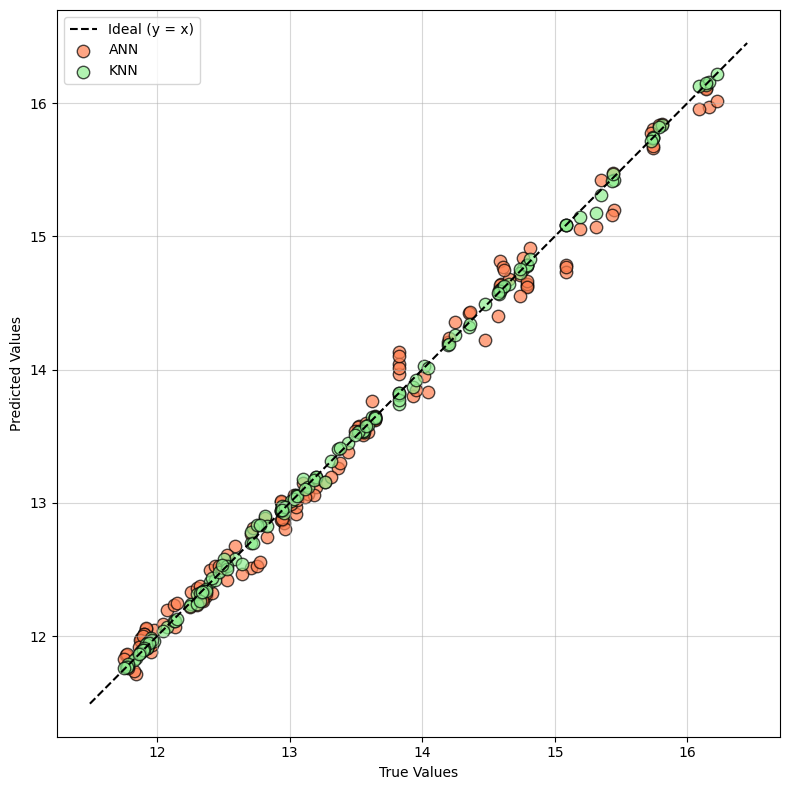

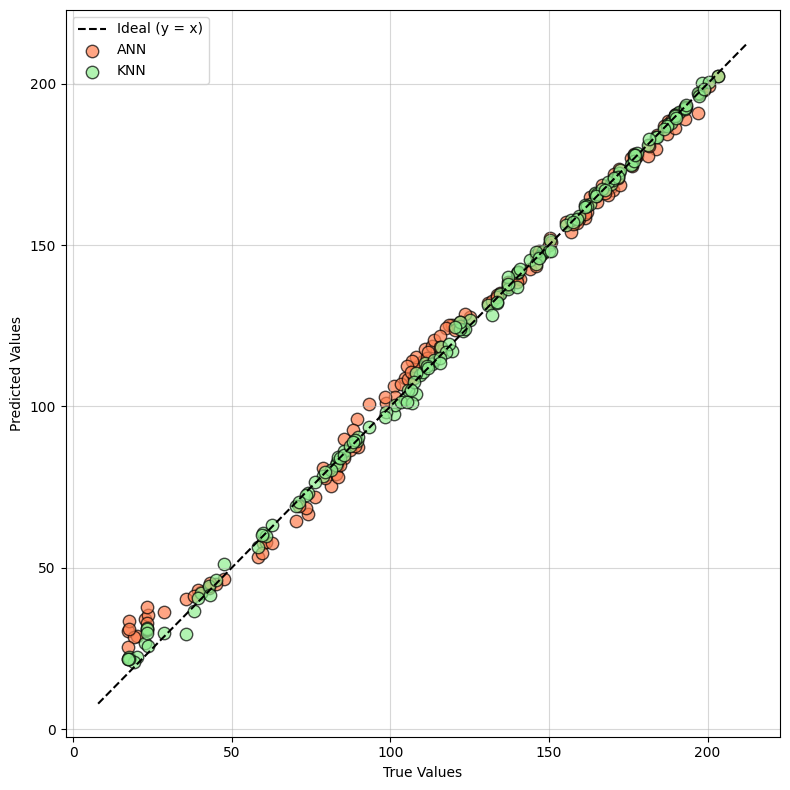

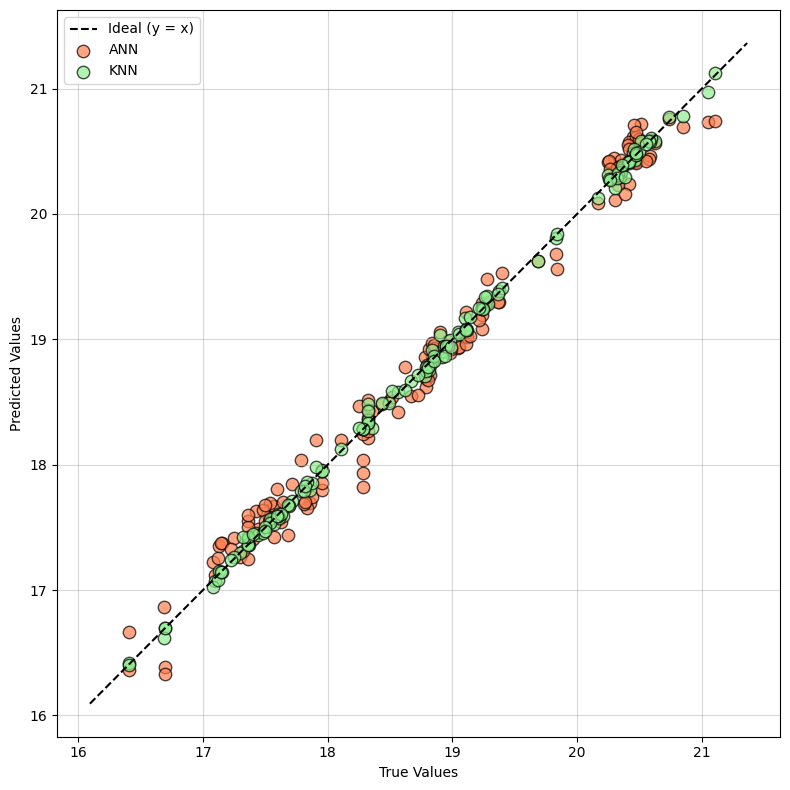

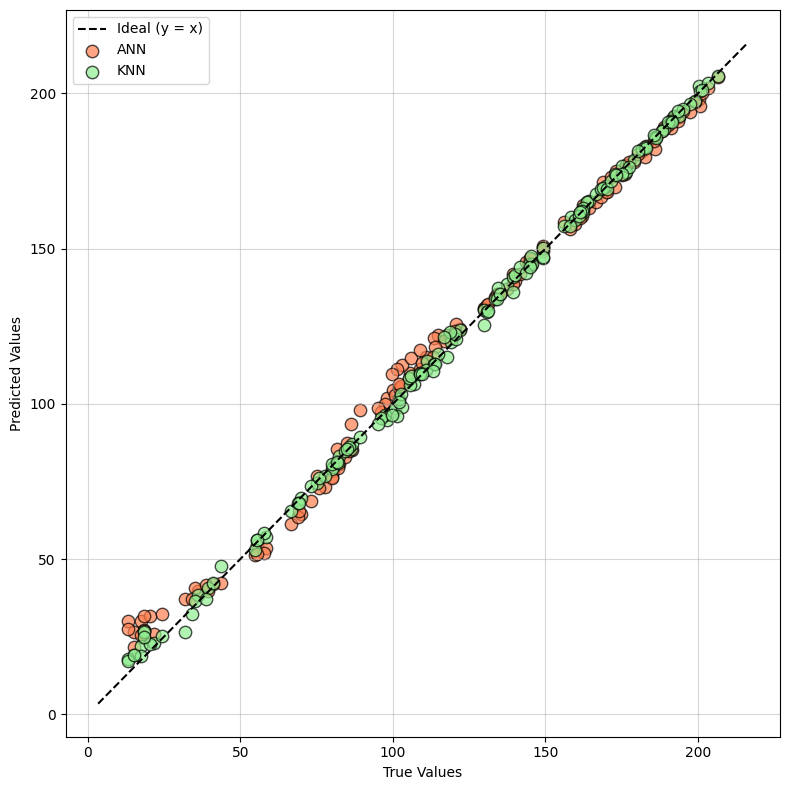

In [12]:
targets = ["angle_mie", "length_mie", "angle_shadow", "length_shadow"]

for target in targets:
    actual = ann_actuals[target].values
    ann_pred = ann_predictions[target].values
    knn_pred = knn_predictions_df[target].values

    r2_ann = r2_score(actual, ann_pred)
    r2_knn = r2_score(actual, knn_pred)

    values = np.concatenate([actual, ann_pred, knn_pred])
    min_v, max_v = values.min(), values.max()
    margin = (max_v - min_v) * 0.05

    plt.figure(figsize=(8, 8), facecolor="white")
    plt.plot(
        [min_v - margin, max_v + margin],
        [min_v - margin, max_v + margin],
        "k--",
        label="Ideal (y = x)",
    )
    plt.scatter(
        actual, ann_pred, alpha=0.7, s=80, color="#FF7F50", edgecolors="black", label="ANN"
    )
    plt.scatter(
        actual, knn_pred, alpha=0.7, s=80, color="#90EE90", edgecolors="black", label="KNN"
    )
    plt.xlabel("True Values")
    plt.ylabel("Predicted Values")
    plt.legend()
    plt.grid(True, alpha=0.5)
    plt.tight_layout()
    plt.savefig(f"plots/8_ann_knn_{target}_comparision.png")
    plt.show()


## 9. KDE plots of residuals for all four target variables predicted by the ANN model

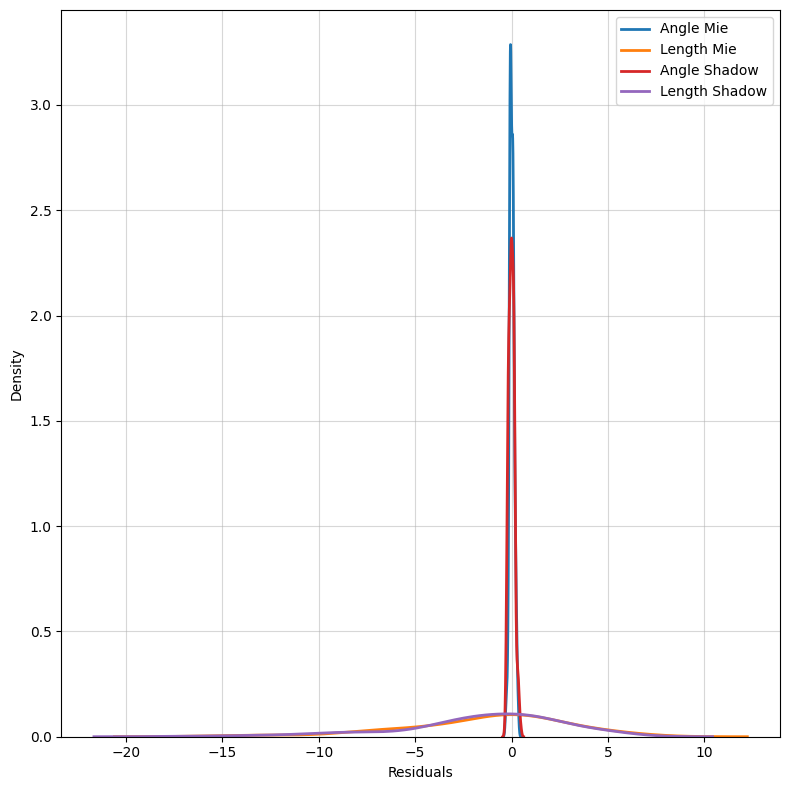

In [13]:
residuals = {t: ann_actuals[t] - ann_predictions[t] for t in targets}
plt.figure(figsize=(8, 8), facecolor="white")
colors = ["#1f77b4", "#ff7f0e", "#d62728", "#9467bd"]
for i, t in enumerate(targets):
    sns.kdeplot(residuals[t], label=t.replace("_", " ").title(), color=colors[i], linewidth=2)
plt.xlabel("Residuals")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.5)
plt.tight_layout()
plt.savefig("plots/9_ann_residuals_kde")
plt.show()